In [1]:
import numpy as np
import pandas as pd
import scipy

from IPython.display import clear_output

import sys
sys.path.append('../../../../Documents/GitHub/gustav/src/')

from gustav import ebi, ncbi, nlm, biogrid, nih
from gustav import publications
from gustav import github
from gustav import access_framework
from gustav import mapper

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../general/src/')
from manuscript import export
from manuscript import inout
from manuscript import datasets
from manuscript import tools

from sklearn.metrics import auc
from scipy.stats import fisher_exact
pd.options.display.precision = 3
pd.options.display.expand_frame_repr = False
pd.options.display.max_columns = 20

In [2]:
taxon = 9606

In [3]:
gene_flavor = 'ou'
ref_genes = datasets.reference_genes(taxon, gene_flavor)

C:\Users\richa\Documents\GitHub\promising_genes\notebooks\../../../../Documents/GitHub/gustav/src\gustav\utils.py:52: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_with_delimiter.drop(column, 1).reset_index(),
C:\Users\richa\Documents\GitHub\promising_genes\notebooks\../../../../Documents/GitHub/gustav/src\gustav\utils.py:63: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  joined = joined.drop('helper_index', 1)


In [4]:
ref_literature = datasets.reference_publications(taxon)

In [5]:
agg = []
literature_flavor = 'pubtator_title_or_abstract_in_any_gene2pubmed_paper'

gene2lit = datasets.reference_gene2lit(
    taxon, 
    literature_flavor)
gene2lit = gene2lit[
    gene2lit['gene_ncbi'].isin(ref_genes) & 
    gene2lit['pubmed_id'].isin(ref_literature)
].copy()

In [6]:
%%time
ml = ncbi.pubmed('main', ['pubmed_id', 'year'])

CPU times: total: 1.81 s
Wall time: 2.21 s


In [7]:
%%time
gene2pubmed = gene2lit #ncbi.gene2pubmed(taxon_ncbi=9606)
large_pubs = gene2pubmed['pubmed_id'].value_counts()[gene2pubmed['pubmed_id'].value_counts() >= 100].index.values
#gene2pubmed = gene2pubmed[~gene2pubmed['pubmed_id'].isin(large_pubs)]

gene2pubmed_dict = gene2pubmed[~gene2pubmed['pubmed_id'].isin(large_pubs)].value_counts('gene_ncbi').to_dict()

CPU times: total: 125 ms
Wall time: 124 ms


In [8]:
time_range_of_interest = range(2014, 2019)
taxon_of_interest = 9606

#gene2pubmed = ncbi.gene2pubmed(taxon_ncbi=taxon_of_interest)
#large_pubs = gene2pubmed['pubmed_id'].value_counts()[gene2pubmed['pubmed_id'].value_counts() >= 100].index.values
#gene2pubmed = gene2pubmed[~gene2pubmed['pubmed_id'].isin(large_pubs)]

gene2pubmed = pd.merge(
    gene2pubmed[['gene_ncbi', 'pubmed_id']].drop_duplicates(),
    ncbi.pubmed('main', ['pubmed_id', 'year']).drop_duplicates()
)

agg = dict()
for year in time_range_of_interest:
     agg[year] = gene2pubmed[
         gene2pubmed['year']<year
     ]['gene_ncbi'].value_counts().reindex(ref_genes).fillna(0)

popularity = pd.DataFrame(agg).rename_axis(index='gene_ncbi', columns='year')
popularity = popularity.rank(pct=True).stack().to_frame('popularity_percentile').reset_index()

icite_studies = nih.icite(
    'studies', 
    columns=['pubmed_id', 'year', 'citations_per_year']
).drop_duplicates().dropna()

icite_studies = icite_studies[
    icite_studies['pubmed_id'].isin(gene2pubmed['pubmed_id'])].copy()

citations = icite_studies.set_index(
    'pubmed_id', verify_integrity=True
).groupby('year')['citations_per_year'].rank(pct=True).to_frame('citation_percentile').reset_index()


meshs = ncbi.pubmed('mesh_terms')

# get publications corresponding to introduction of a MeSH term (note: does not consider children of MeSH)
helper = pd.merge(
    gene2pubmed, 
    meshs)

all_gene_pubs = pd.merge(helper, citations)
all_gene_pubs = all_gene_pubs[all_gene_pubs['year'].isin(time_range_of_interest)]

keeper = helper.groupby(['gene_ncbi', 'mesh_terms'])['year'].min().to_frame('year').reset_index()
helper = pd.merge(helper, keeper)

toy = pd.merge(helper, citations)
toy = pd.merge(toy, popularity)

In [9]:
results = pd.DataFrame(all_gene_pubs.groupby('mesh_terms').median()['citation_percentile'])
results.columns = ['citation_percentile_all']
results['citation_percentile_intro'] = toy.groupby('mesh_terms').median()['citation_percentile']
results['n_pubs_all'] = all_gene_pubs.groupby('mesh_terms').nunique()['pubmed_id']
results['n_pubs_intro'] = toy.groupby('mesh_terms').nunique()['pubmed_id']
results = results.reset_index()
results = results.rename(columns={'mesh_terms':'term'})

In [10]:
mesh_library = nlm.mesh('ui2mn')
disease_ui = mesh_library[mesh_library['mn'].str.startswith('C')]['ui'].values
results['ui'] = results['term'].apply(lambda x: x.split(':')[0])

In [12]:
results['disease_term'] = results['ui'].isin(disease_ui)

In [13]:
results.to_csv('../data/new_gene_introductions_vs_old_genes_by_mesh.csv', index=False)

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


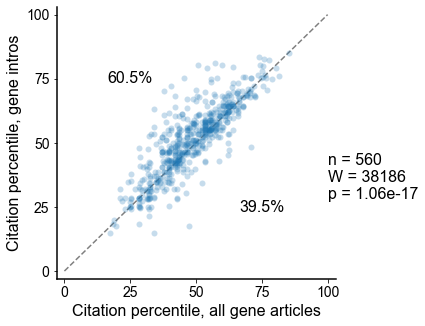

In [60]:
fig = plt.figure(figsize=(5,5))
ax = plt.gca()

results_slice = results[(results['ui'].isin(disease_ui)) & 
                        (results['n_pubs_all'] - results['n_pubs_intro'] >= 15) & 
                        (results['n_pubs_intro'] >= 15)].copy()

stat, p = scipy.stats.wilcoxon(results_slice['citation_percentile_all'], 
                     results_slice['citation_percentile_intro'])

ax.scatter(results_slice['citation_percentile_all'], 
            results_slice['citation_percentile_intro'], 
           alpha=0.25, linewidth=0)

ax.plot([0,1], [0,1], 
        zorder=-1, color='k', alpha=0.5, linestyle='dashed')

pc_above = np.mean(results_slice['citation_percentile_all'] < results_slice['citation_percentile_intro'])

ax.text(s='{:.1f}%'.format(100*pc_above), 
        x=0.25, y=0.75, 
        ha='center', va='center', 
        fontsize=16)

ax.text(s='{:.1f}%'.format(100*(1-pc_above)), 
        x=0.75, y=0.25, 
        ha='center', va='center', 
        fontsize=16)

ax.text(s='\nn = {:.0f}'.format(len(results_slice)) + 
        '\nW = {:.0f}'.format(stat) + '\np = {:.2e}'.format(p), 
        x=1, y=0.4, 
        ha='left', va='center', 
        fontsize=16)

ax.tick_params(labelsize=14)
ax.set_ylabel('Citation percentile, gene intros', fontsize=16)
ax.set_xlabel('Citation percentile, all gene articles', fontsize=16)
[ax.spines[i].set_linewidth(1.5) for i in ax.spines]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim([-0.03,1.03])
ax.set_ylim([-0.03,1.03])
ax.set_xticks([0,0.25,0.5,0.75,1.0], labels=[0,25,50,75,100])
ax.set_yticks([0,0.25,0.5,0.75,1.0], labels=[0,25,50,75,100])

plt.savefig('../img/supp_fig_intros_get_more_220831.png', dpi=200, bbox_inches='tight')
plt.savefig('../img/supp_fig_intros_get_more_220831.pdf', bbox_inches='tight')

export.image('general', p='figures/supp_fig_intros_get_more_.pdf', date=True)
export.raster_image('general', p='figures/supp_fig_intros_get_more_.png', date=True, dpi=600)

In [56]:
np.mean(results_slice['citation_percentile_all'] < results_slice['citation_percentile_intro'])

0.6053571428571428

In [57]:
scipy.stats.wilcoxon(results_slice['citation_percentile_all'], 
                     results_slice['citation_percentile_intro'])

WilcoxonResult(statistic=38186.5, pvalue=1.0609319938931437e-17)

In [58]:
p

1.0609319938931437e-17

In [61]:
results_slice['delta'] = results_slice['citation_percentile_intro'] - results_slice['citation_percentile_all']

In [65]:
results_slice.sort_values('delta', ascending=False).head(10)

,term,citation_percentile_all,citation_percentile_intro,n_pubs_all,n_pubs_intro,ui,delta
9088,D014071:Tooth Abnormalities,0.377,0.704,44,16.0,D014071,0.327
6566,D009503:Neutropenia,0.407,0.722,75,23.0,D009503,0.316
6344,D009136:Muscular Dystrophies,0.455,0.754,68,27.0,D009136,0.299
10885,"D017545:Aortic Aneurysm, Thoracic",0.508,0.802,63,32.0,D017545,0.294
6822,D010009:Osteochondrodysplasias,0.342,0.633,148,57.0,D010009,0.291
3141,D003560:Cysts,0.421,0.684,54,29.0,D003560,0.263
4019,D005199:Fanconi Anemia,0.542,0.792,95,28.0,D005199,0.249
10390,D016511:Severe Combined Immunodeficiency,0.573,0.812,38,15.0,D016511,0.239
14049,"D049288:Muscular Dystrophies, Limb-Girdle",0.377,0.610,79,20.0,D049288,0.233
13492,"D040181:Genetic Diseases, X-Linked",0.396,0.617,202,71.0,D040181,0.221
